In [1]:
import numpy as np
import pandas as pd
import requests
import bs4
import lxml.etree as xml
import os
import glob

## Scrap data  
for both hespress and ledesk we will use the title of articles in the last two years
### hespress

In [2]:
# from urllib.request import urlopen

# titles = []

# start = 1
# stop = 3001
# for i in range(start, stop):
#     URL = "https://fr.hespress.com/?action=ajax_listing&paged="+str(i)+"&tq=MjAyMS0wMS0wNCAxMzo0MDo1NA%3D%3D&all_listing=1"

#     html = urlopen(URL)
    
#     web_page = bs4.BeautifulSoup(html, "lxml")

#     all_links = web_page.find_all(name="a")
    
    
    
#     for link in all_links:
#         titles.append(link.attrs["title"])
        

### ledesk

In [3]:
# all_titles= []

# start = 1
# stop = 4000

# for i in range(start, stop):
#     URL = "https://ledesk.ma/ajax/?action=infinit_encontinu&els="+str(i)

#     html = urlopen(URL)

#     web_page = bs4.BeautifulSoup(html, "lxml")

#     all_links = web_page.find_all(name="a", attrs={"class" : "global-title"})

#     for l in all_links:
#         all_titles.append(l.text)
#     print(i)


In [4]:
# df = pd.DataFrame(data={"title": all_titles})

# path = "./"+str(start)+"to"+str(stop)+"--ledesk.csv"

# df.to_csv(path, sep=',',index=False, encoding='utf-16')

### exporting peaces of files

In [5]:
# df = pd.DataFrame(data={"title": titles})

# path = "./"+str(start)+"to"+str(stop)+".csv"

# df.to_csv(path, sep=',',index=False, encoding='utf-16')

### merge excel files of hespress

In [6]:
# path = r'C:\Users\Abdou\Python Projects\Text Mining\Social media'
# all_files = glob.glob(path + "/*.csv")
# li = []

# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0, encoding='utf-16')
#     li.append(df)

# frame = pd.concat(li, axis=0, ignore_index=True)

#len(frame)

In [7]:
# #export to csv
# frame.to_csv( "combined_csv.csv", index=False, encoding='utf-16')

### loading data

In [8]:
all_titles = pd.read_csv('combined_csv.csv', encoding="utf-16")
len(all_titles)

95688

### Cleaning data

In [9]:
import re

# remove ponctuation
all_titles['title_processed'] = all_titles['title'].map(lambda x: re.sub('[,\.!?]', '', x))

In [10]:
print(all_titles.loc[28].title)
print(all_titles.loc[28].title_processed)

Protection des zones humides: Le Maroc peut mieux faire!
Protection des zones humides: Le Maroc peut mieux faire


In [11]:
# transform to lowercase
all_titles['title_processed'] = all_titles['title_processed'].map(lambda x: x.lower() )

### make a word cloud using the wordcloud package to get a visual representation of most common words

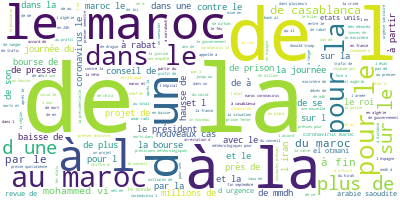

In [12]:
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(all_titles['title_processed'].values))

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

### Prepare text for LDA analysis 

In [13]:
import gensim
from gensim.utils import simple_preprocess
import nltk
from nltk.corpus import stopwords

stop_words = nltk.corpus.stopwords.words('french')

#### add word maroc to stop words to be removed

In [14]:
stop_words.extend(['maroc', 'mmdh'])

In [15]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

#tokenization
data = all_titles.title_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

print(data_words[:1][0])

['coupe', 'arabe', 'demi', 'finale']


In [16]:
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(data_words)

# Create Corpus
texts = data_words

# Term Document Frequency : bag of words
corpus = [id2word.doc2bow(text) for text in texts]

# See
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1)]


### LDA model tranining

In [17]:
from pprint import pprint

# number of topics
num_topics = 85

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)

# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(82,
  '0.077*"enquete" + 0.034*"ecoles" + 0.028*"decision" + 0.027*"droit" + '
  '0.027*"destination" + 0.027*"vote" + 0.025*"parlementaire" + 0.025*"promet" '
  '+ 0.024*"sites" + 0.023*"radio"'),
 (57,
  '0.058*"partir" + 0.057*"age" + 0.048*"essentiel" + 0.045*"jusqu" + '
  '0.042*"terrorisme" + 0.036*"nouvel" + 0.034*"franco" + 0.034*"risque" + '
  '0.030*"espagnole" + 0.028*"fete"'),
 (75,
  '0.139*"armee" + 0.097*"journee" + 0.065*"mardi" + 0.058*"lundi" + '
  '0.041*"rue" + 0.039*"prevues" + 0.032*"attaques" + 0.031*"construction" + '
  '0.027*"mondiale" + 0.022*"chomage"'),
 (32,
  '0.058*"secteur" + 0.038*"prive" + 0.032*"pape" + 0.031*"israelienne" + '
  '0.023*"americano" + 0.022*"devrait" + 0.021*"retrait" + 0.021*"francois" + '
  '0.020*"vont" + 0.020*"abus"'),
 (0,
  '0.037*"essais" + 0.033*"cliniques" + 0.027*"covid" + 0.027*"grippe" + '
  '0.027*"vaccin" + 0.026*"virus" + 0.026*"dedie" + 0.025*"exercice" + '
  '0.023*"sanitaires" + 0.017*"annuel"'),
 (78,
  '0.064*"pa

### Visualization of our LDA model
After generating the visualization of our model, we will save this visualization in "results" folder.

In [18]:
import pyLDAvis.gensim
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))

# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)


pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
13     0.098865 -0.042870       1        1  1.735954
51    -0.034771 -0.060923       2        1  1.636622
24    -0.154632  0.107532       3        1  1.554209
21    -0.022707  0.043802       4        1  1.527497
60    -0.199257  0.093636       5        1  1.485179
...         ...       ...     ...      ...       ...
6      0.075098 -0.016216      81        1  0.940722
33     0.054416  0.016957      82        1  0.933063
32    -0.063882 -0.017745      83        1  0.932245
56     0.032210 -0.106516      84        1  0.917376
48    -0.145749  0.016578      85        1  0.902122

[85 rows x 5 columns], topic_info=          Term         Freq        Total Category  logprob  loglift
327        fin  2572.000000  2572.000000  Default  30.0000  30.0000
264   mohammed  2004.000000  2004.000000  Default  29.0000  29.0000
269         vi  1764.000000  1764.000000  Default  28.0000  28.0000
24     premier  1780.000000  1780.000000  Default  27.0000  27.0000
351      trump  1991.000000  1991.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
536       deux    54.422029  2792.965026  Topic85  -4.6945   0.7701
443       mort    50.346571  1064.322382  Topic85  -4.7723   1.6570
1344      tete    47.627372   646.040380  Topic85  -4.8279   2.1007
864      leurs    45.721502   596.893886  Topic85  -4.8687   2.1390
130       plus    46.073149  3853.749912  Topic85  -4.8610   0.2816

[4337 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
5907      70  0.939809  abandon
2580      15  0.980829   abattu
2580      50  0.016079   abattu
2584      33  0.932537    abbas
2584      40  0.009420    abbas
...      ...       ...      ...
10074     80  0.956109     zuma
3070      22  0.077552    œuvre
3070      62  0.012925    œuvre
3070      67  0.878927    œuvre
3070      77  0.012925    œuvre

[19845 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[14, 52, 25, 22, 61, 11, 55, 75, 40, 20, 38, 9, 47, 41, 51, 67, 3, 74, 44, 29, 30, 64, 32, 80, 69, 36, 10, 35, 37, 2, 53, 70, 79, 8, 85, 48, 43, 5, 62, 42, 6, 71, 58, 56, 15, 78, 23, 4, 27, 17, 81, 16, 66, 54, 59, 82, 83, 68, 28, 26, 76, 31, 1, 84, 50, 18, 46, 60, 21, 19, 65, 72, 13, 73, 63, 12, 24, 39, 77, 45, 7, 34, 33, 57, 49])

In [20]:
# Eval via coherence scoring
from gensim import corpora, models
from gensim.models import CoherenceModel
from pprint import pprint

coh = CoherenceModel(model=lda_model, texts= data_words, dictionary = id2word, coherence = "c_v")
coh_lda = coh.get_coherence()

print("Coherence Score:", coh_lda)

C:\Users\Abdou\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score: 0.5901858581530561
